# 检查cuda版本

###  安装 过程请参考
https://github.com/graphdeco-inria/gaussian-splatting
#### 本ipynb的版本是cuda11.8 pytorch2.0 

### 训练数据集下载
!wget https://huggingface.co/camenduru/gaussian-splatting/resolve/main/tandt_db.zip

在gaussian-splatting文件夹下解压

!unzip tandt_db.zip

In [1]:
import torch

# 检查 CUDA (GPU 支持) 是否可用
cuda_available = torch.cuda.is_available()

print("CUDA Available:", cuda_available)

# 如果 CUDA 可用，打印出 GPU 的数量和名称
if cuda_available:
    print("Number of GPUs Available:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


# 检查 CUDA 是否可用
print("CUDA Available:", torch.cuda.is_available())

# 显示 PyTorch 使用的 CUDA 版本
print("CUDA Version:", torch.version.cuda)

# 显示 PyTorch 使用的 cuDNN 版本
print("cuDNN Version:", torch.backends.cudnn.version())

# 显示当前选定的 CUDA 设备
print("Current CUDA Device:", torch.cuda.current_device())

# 显示当前 CUDA 设备的名称（例如，您的 GPU 名称）
print("CUDA Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA Available: True
Number of GPUs Available: 1
GPU 0: NVIDIA GeForce RTX 3090
CUDA Available: True
CUDA Version: 11.8
cuDNN Version: 8700
Current CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 3090


# 打印工作目录

In [2]:
%cd ./gaussian-splatting/
import os

# 获取并打印当前工作目录
current_working_directory = os.getcwd()
print("当前工作目录：", current_working_directory)

[Errno 2] No such file or directory: './gaussian-splatting/'
/root/autodl-tmp/gaussian-splatting
当前工作目录： /root/autodl-tmp/gaussian-splatting


# 开始3dgs

# 训练用到的模型-类文件

# 可视化用到的函数

In [3]:
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

# 假设 image 和 gt_image 都是 PyTorch 张量，形状为 [C, H, W]，且数据范围在 [0, 1]
# 转换为 numpy 并调整为 [H, W, C] 以适应 Matplotlib
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().permute(1, 2, 0).numpy()

# 可视化函数
def visualize_images(image_tensor, gt_image_tensor):
    # 清除之前的输出
    clear_output(wait=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 显示 image
    axes[0].imshow(tensor_to_numpy(image_tensor))
    axes[0].set_title('Rendered Image')
    axes[0].axis('off')

    # 显示 gt_image
    axes[1].imshow(tensor_to_numpy(gt_image_tensor))
    axes[1].set_title('Ground Truth Image')
    axes[1].axis('off')

    plt.show()

# 调用函数进行可视化
# visualize_images(image, gt_image)


### autodl-tmp/gaussian-splatting/scene/gaussian_model.py
3dgs模型的类函数

In [4]:
import torch
import numpy as np
from utils.general_utils import inverse_sigmoid, get_expon_lr_func, build_rotation
from torch import nn
import os
from utils.system_utils import mkdir_p
from plyfile import PlyData, PlyElement
from utils.sh_utils import RGB2SH
from simple_knn._C import distCUDA2
from utils.graphics_utils import BasicPointCloud
from utils.general_utils import strip_symmetric, build_scaling_rotation

class GaussianModel:

    def setup_functions(self):
        def build_covariance_from_scaling_rotation(scaling, scaling_modifier, rotation):
            L = build_scaling_rotation(scaling_modifier * scaling, rotation)
            actual_covariance = L @ L.transpose(1, 2)
            symm = strip_symmetric(actual_covariance)
            return symm
        
        self.scaling_activation = torch.exp
        self.scaling_inverse_activation = torch.log

        self.covariance_activation = build_covariance_from_scaling_rotation

        self.opacity_activation = torch.sigmoid
        self.inverse_opacity_activation = inverse_sigmoid

        self.rotation_activation = torch.nn.functional.normalize


    def __init__(self, sh_degree : int):
        self.active_sh_degree = 0
        self.max_sh_degree = sh_degree  
        self._xyz = torch.empty(0)
        self._features_dc = torch.empty(0)
        self._features_rest = torch.empty(0)
        self._scaling = torch.empty(0)
        self._rotation = torch.empty(0)
        self._opacity = torch.empty(0)
        self.max_radii2D = torch.empty(0)
        self.xyz_gradient_accum = torch.empty(0)
        self.denom = torch.empty(0)
        self.optimizer = None
        self.percent_dense = 0
        self.spatial_lr_scale = 0
        self.setup_functions()

    def capture(self):
        return (
            self.active_sh_degree,
            self._xyz,
            self._features_dc,
            self._features_rest,
            self._scaling,
            self._rotation,
            self._opacity,
            self.max_radii2D,
            self.xyz_gradient_accum,
            self.denom,
            self.optimizer.state_dict(),
            self.spatial_lr_scale,
        )
    
    def restore(self, model_args, training_args):
        (self.active_sh_degree, 
        self._xyz, 
        self._features_dc, 
        self._features_rest,
        self._scaling, 
        self._rotation, 
        self._opacity,
        self.max_radii2D, 
        xyz_gradient_accum, 
        denom,
        opt_dict, 
        self.spatial_lr_scale) = model_args
        self.training_setup(training_args)
        self.xyz_gradient_accum = xyz_gradient_accum
        self.denom = denom
        self.optimizer.load_state_dict(opt_dict)

    @property
    def get_scaling(self):
        return self.scaling_activation(self._scaling)
    
    @property
    def get_rotation(self):
        return self.rotation_activation(self._rotation)
    
    @property
    def get_xyz(self):
        return self._xyz
    
    @property
    def get_features(self):
        features_dc = self._features_dc
        features_rest = self._features_rest
        return torch.cat((features_dc, features_rest), dim=1)
    
    @property
    def get_opacity(self):
        return self.opacity_activation(self._opacity)
    
    def get_covariance(self, scaling_modifier = 1):
        return self.covariance_activation(self.get_scaling, scaling_modifier, self._rotation)

    def oneupSHdegree(self):
        if self.active_sh_degree < self.max_sh_degree:
            self.active_sh_degree += 1

    def create_from_pcd(self, pcd : BasicPointCloud, spatial_lr_scale : float):
        self.spatial_lr_scale = spatial_lr_scale
        fused_point_cloud = torch.tensor(np.asarray(pcd.points)).float().cuda()
        fused_color = RGB2SH(torch.tensor(np.asarray(pcd.colors)).float().cuda())
        features = torch.zeros((fused_color.shape[0], 3, (self.max_sh_degree + 1) ** 2)).float().cuda()
        features[:, :3, 0 ] = fused_color
        features[:, 3:, 1:] = 0.0

        print("Number of points at initialisation : ", fused_point_cloud.shape[0])

        dist2 = torch.clamp_min(distCUDA2(torch.from_numpy(np.asarray(pcd.points)).float().cuda()), 0.0000001)
        scales = torch.log(torch.sqrt(dist2))[...,None].repeat(1, 3)
        rots = torch.zeros((fused_point_cloud.shape[0], 4), device="cuda")
        rots[:, 0] = 1

        opacities = inverse_sigmoid(0.1 * torch.ones((fused_point_cloud.shape[0], 1), dtype=torch.float, device="cuda"))

        self._xyz = nn.Parameter(fused_point_cloud.requires_grad_(True))
        self._features_dc = nn.Parameter(features[:,:,0:1].transpose(1, 2).contiguous().requires_grad_(True))
        self._features_rest = nn.Parameter(features[:,:,1:].transpose(1, 2).contiguous().requires_grad_(True))
        self._scaling = nn.Parameter(scales.requires_grad_(True))
        self._rotation = nn.Parameter(rots.requires_grad_(True))
        self._opacity = nn.Parameter(opacities.requires_grad_(True))
        self.max_radii2D = torch.zeros((self.get_xyz.shape[0]), device="cuda")

    def training_setup(self, training_args):
        self.percent_dense = training_args.percent_dense
        self.xyz_gradient_accum = torch.zeros((self.get_xyz.shape[0], 1), device="cuda")
        self.denom = torch.zeros((self.get_xyz.shape[0], 1), device="cuda")

        l = [
            {'params': [self._xyz], 'lr': training_args.position_lr_init * self.spatial_lr_scale, "name": "xyz"},
            {'params': [self._features_dc], 'lr': training_args.feature_lr, "name": "f_dc"},
            {'params': [self._features_rest], 'lr': training_args.feature_lr / 20.0, "name": "f_rest"},
            {'params': [self._opacity], 'lr': training_args.opacity_lr, "name": "opacity"},
            {'params': [self._scaling], 'lr': training_args.scaling_lr, "name": "scaling"},
            {'params': [self._rotation], 'lr': training_args.rotation_lr, "name": "rotation"}
        ]

        self.optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)
        self.xyz_scheduler_args = get_expon_lr_func(lr_init=training_args.position_lr_init*self.spatial_lr_scale,
                                                    lr_final=training_args.position_lr_final*self.spatial_lr_scale,
                                                    lr_delay_mult=training_args.position_lr_delay_mult,
                                                    max_steps=training_args.position_lr_max_steps)

    def update_learning_rate(self, iteration):
        ''' Learning rate scheduling per step '''
        for param_group in self.optimizer.param_groups:
            if param_group["name"] == "xyz":
                lr = self.xyz_scheduler_args(iteration)
                param_group['lr'] = lr
                return lr

    def construct_list_of_attributes(self):
        l = ['x', 'y', 'z', 'nx', 'ny', 'nz']
        # All channels except the 3 DC
        for i in range(self._features_dc.shape[1]*self._features_dc.shape[2]):
            l.append('f_dc_{}'.format(i))
        for i in range(self._features_rest.shape[1]*self._features_rest.shape[2]):
            l.append('f_rest_{}'.format(i))
        l.append('opacity')
        for i in range(self._scaling.shape[1]):
            l.append('scale_{}'.format(i))
        for i in range(self._rotation.shape[1]):
            l.append('rot_{}'.format(i))
        return l

    def save_ply(self, path):
        mkdir_p(os.path.dirname(path))

        xyz = self._xyz.detach().cpu().numpy()
        normals = np.zeros_like(xyz)
        f_dc = self._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        f_rest = self._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        opacities = self._opacity.detach().cpu().numpy()
        scale = self._scaling.detach().cpu().numpy()
        rotation = self._rotation.detach().cpu().numpy()

        dtype_full = [(attribute, 'f4') for attribute in self.construct_list_of_attributes()]

        elements = np.empty(xyz.shape[0], dtype=dtype_full)
        attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
        elements[:] = list(map(tuple, attributes))
        el = PlyElement.describe(elements, 'vertex')
        PlyData([el]).write(path)

    def reset_opacity(self):
        opacities_new = inverse_sigmoid(torch.min(self.get_opacity, torch.ones_like(self.get_opacity)*0.01))
        optimizable_tensors = self.replace_tensor_to_optimizer(opacities_new, "opacity")
        self._opacity = optimizable_tensors["opacity"]

    def load_ply(self, path):
        plydata = PlyData.read(path)

        xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                        np.asarray(plydata.elements[0]["y"]),
                        np.asarray(plydata.elements[0]["z"])),  axis=1)
        opacities = np.asarray(plydata.elements[0]["opacity"])[..., np.newaxis]

        features_dc = np.zeros((xyz.shape[0], 3, 1))
        features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
        features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
        features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

        extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
        extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
        assert len(extra_f_names)==3*(self.max_sh_degree + 1) ** 2 - 3
        features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
        for idx, attr_name in enumerate(extra_f_names):
            features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
        # Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
        features_extra = features_extra.reshape((features_extra.shape[0], 3, (self.max_sh_degree + 1) ** 2 - 1))

        scale_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("scale_")]
        scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
        scales = np.zeros((xyz.shape[0], len(scale_names)))
        for idx, attr_name in enumerate(scale_names):
            scales[:, idx] = np.asarray(plydata.elements[0][attr_name])

        rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
        rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
        rots = np.zeros((xyz.shape[0], len(rot_names)))
        for idx, attr_name in enumerate(rot_names):
            rots[:, idx] = np.asarray(plydata.elements[0][attr_name])

        self._xyz = nn.Parameter(torch.tensor(xyz, dtype=torch.float, device="cuda").requires_grad_(True))
        self._features_dc = nn.Parameter(torch.tensor(features_dc, dtype=torch.float, device="cuda").transpose(1, 2).contiguous().requires_grad_(True))
        self._features_rest = nn.Parameter(torch.tensor(features_extra, dtype=torch.float, device="cuda").transpose(1, 2).contiguous().requires_grad_(True))
        self._opacity = nn.Parameter(torch.tensor(opacities, dtype=torch.float, device="cuda").requires_grad_(True))
        self._scaling = nn.Parameter(torch.tensor(scales, dtype=torch.float, device="cuda").requires_grad_(True))
        self._rotation = nn.Parameter(torch.tensor(rots, dtype=torch.float, device="cuda").requires_grad_(True))

        self.active_sh_degree = self.max_sh_degree

    def replace_tensor_to_optimizer(self, tensor, name):
        optimizable_tensors = {}
        for group in self.optimizer.param_groups:
            if group["name"] == name:
                stored_state = self.optimizer.state.get(group['params'][0], None)
                stored_state["exp_avg"] = torch.zeros_like(tensor)
                stored_state["exp_avg_sq"] = torch.zeros_like(tensor)

                del self.optimizer.state[group['params'][0]]
                group["params"][0] = nn.Parameter(tensor.requires_grad_(True))
                self.optimizer.state[group['params'][0]] = stored_state

                optimizable_tensors[group["name"]] = group["params"][0]
        return optimizable_tensors

    def _prune_optimizer(self, mask):
        optimizable_tensors = {}
        for group in self.optimizer.param_groups:
            stored_state = self.optimizer.state.get(group['params'][0], None)
            if stored_state is not None:
                stored_state["exp_avg"] = stored_state["exp_avg"][mask]
                stored_state["exp_avg_sq"] = stored_state["exp_avg_sq"][mask]

                del self.optimizer.state[group['params'][0]]
                group["params"][0] = nn.Parameter((group["params"][0][mask].requires_grad_(True)))
                self.optimizer.state[group['params'][0]] = stored_state

                optimizable_tensors[group["name"]] = group["params"][0]
            else:
                group["params"][0] = nn.Parameter(group["params"][0][mask].requires_grad_(True))
                optimizable_tensors[group["name"]] = group["params"][0]
        return optimizable_tensors

    def prune_points(self, mask):
        valid_points_mask = ~mask
        optimizable_tensors = self._prune_optimizer(valid_points_mask)

        self._xyz = optimizable_tensors["xyz"]
        self._features_dc = optimizable_tensors["f_dc"]
        self._features_rest = optimizable_tensors["f_rest"]
        self._opacity = optimizable_tensors["opacity"]
        self._scaling = optimizable_tensors["scaling"]
        self._rotation = optimizable_tensors["rotation"]

        self.xyz_gradient_accum = self.xyz_gradient_accum[valid_points_mask]

        self.denom = self.denom[valid_points_mask]
        self.max_radii2D = self.max_radii2D[valid_points_mask]

    def cat_tensors_to_optimizer(self, tensors_dict):
        optimizable_tensors = {}
        for group in self.optimizer.param_groups:
            assert len(group["params"]) == 1
            extension_tensor = tensors_dict[group["name"]]
            stored_state = self.optimizer.state.get(group['params'][0], None)
            if stored_state is not None:

                stored_state["exp_avg"] = torch.cat((stored_state["exp_avg"], torch.zeros_like(extension_tensor)), dim=0)
                stored_state["exp_avg_sq"] = torch.cat((stored_state["exp_avg_sq"], torch.zeros_like(extension_tensor)), dim=0)

                del self.optimizer.state[group['params'][0]]
                group["params"][0] = nn.Parameter(torch.cat((group["params"][0], extension_tensor), dim=0).requires_grad_(True))
                self.optimizer.state[group['params'][0]] = stored_state

                optimizable_tensors[group["name"]] = group["params"][0]
            else:
                group["params"][0] = nn.Parameter(torch.cat((group["params"][0], extension_tensor), dim=0).requires_grad_(True))
                optimizable_tensors[group["name"]] = group["params"][0]

        return optimizable_tensors

    def densification_postfix(self, new_xyz, new_features_dc, new_features_rest, new_opacities, new_scaling, new_rotation):
        d = {"xyz": new_xyz,
        "f_dc": new_features_dc,
        "f_rest": new_features_rest,
        "opacity": new_opacities,
        "scaling" : new_scaling,
        "rotation" : new_rotation}

        optimizable_tensors = self.cat_tensors_to_optimizer(d)
        self._xyz = optimizable_tensors["xyz"]
        self._features_dc = optimizable_tensors["f_dc"]
        self._features_rest = optimizable_tensors["f_rest"]
        self._opacity = optimizable_tensors["opacity"]
        self._scaling = optimizable_tensors["scaling"]
        self._rotation = optimizable_tensors["rotation"]

        self.xyz_gradient_accum = torch.zeros((self.get_xyz.shape[0], 1), device="cuda")
        self.denom = torch.zeros((self.get_xyz.shape[0], 1), device="cuda")
        self.max_radii2D = torch.zeros((self.get_xyz.shape[0]), device="cuda")

    def densify_and_split(self, grads, grad_threshold, scene_extent, N=2):
        n_init_points = self.get_xyz.shape[0]
        # Extract points that satisfy the gradient condition
        padded_grad = torch.zeros((n_init_points), device="cuda")
        padded_grad[:grads.shape[0]] = grads.squeeze()
        selected_pts_mask = torch.where(padded_grad >= grad_threshold, True, False)
        selected_pts_mask = torch.logical_and(selected_pts_mask,
                                              torch.max(self.get_scaling, dim=1).values > self.percent_dense*scene_extent)

        stds = self.get_scaling[selected_pts_mask].repeat(N,1)
        means =torch.zeros((stds.size(0), 3),device="cuda")
        samples = torch.normal(mean=means, std=stds)
        rots = build_rotation(self._rotation[selected_pts_mask]).repeat(N,1,1)
        new_xyz = torch.bmm(rots, samples.unsqueeze(-1)).squeeze(-1) + self.get_xyz[selected_pts_mask].repeat(N, 1)
        new_scaling = self.scaling_inverse_activation(self.get_scaling[selected_pts_mask].repeat(N,1) / (0.8*N))
        new_rotation = self._rotation[selected_pts_mask].repeat(N,1)
        new_features_dc = self._features_dc[selected_pts_mask].repeat(N,1,1)
        new_features_rest = self._features_rest[selected_pts_mask].repeat(N,1,1)
        new_opacity = self._opacity[selected_pts_mask].repeat(N,1)

        self.densification_postfix(new_xyz, new_features_dc, new_features_rest, new_opacity, new_scaling, new_rotation)

        prune_filter = torch.cat((selected_pts_mask, torch.zeros(N * selected_pts_mask.sum(), device="cuda", dtype=bool)))
        self.prune_points(prune_filter)

    def densify_and_clone(self, grads, grad_threshold, scene_extent):
        # Extract points that satisfy the gradient condition
        selected_pts_mask = torch.where(torch.norm(grads, dim=-1) >= grad_threshold, True, False)
        selected_pts_mask = torch.logical_and(selected_pts_mask,
                                              torch.max(self.get_scaling, dim=1).values <= self.percent_dense*scene_extent)
        
        new_xyz = self._xyz[selected_pts_mask]
        new_features_dc = self._features_dc[selected_pts_mask]
        new_features_rest = self._features_rest[selected_pts_mask]
        new_opacities = self._opacity[selected_pts_mask]
        new_scaling = self._scaling[selected_pts_mask]
        new_rotation = self._rotation[selected_pts_mask]

        self.densification_postfix(new_xyz, new_features_dc, new_features_rest, new_opacities, new_scaling, new_rotation)

    def densify_and_prune(self, max_grad, min_opacity, extent, max_screen_size):
        grads = self.xyz_gradient_accum / self.denom
        grads[grads.isnan()] = 0.0

        self.densify_and_clone(grads, max_grad, extent)
        self.densify_and_split(grads, max_grad, extent)

        prune_mask = (self.get_opacity < min_opacity).squeeze()
        if max_screen_size:
            big_points_vs = self.max_radii2D > max_screen_size
            big_points_ws = self.get_scaling.max(dim=1).values > 0.1 * extent
            prune_mask = torch.logical_or(torch.logical_or(prune_mask, big_points_vs), big_points_ws)
        self.prune_points(prune_mask)

        torch.cuda.empty_cache()

    def add_densification_stats(self, viewspace_point_tensor, update_filter):
        self.xyz_gradient_accum[update_filter] += torch.norm(viewspace_point_tensor.grad[update_filter,:2], dim=-1, keepdim=True)
        self.denom[update_filter] += 1

### autodl-tmp/gaussian-splatting/scene/__init__.py
 根据3dgs模型初始化scene

In [5]:
import os
import random
import json
from utils.system_utils import searchForMaxIteration
from scene.dataset_readers import sceneLoadTypeCallbacks
# from scene.gaussian_model import GaussianModel
from arguments import ModelParams
from utils.camera_utils import cameraList_from_camInfos, camera_to_JSON

class Scene:

    gaussians : GaussianModel

    def __init__(self, args : ModelParams, gaussians : GaussianModel, load_iteration=None, shuffle=True, resolution_scales=[1.0]):
        """b
        :param path: Path to colmap scene main folder.
        """
        self.model_path = args.model_path
        self.loaded_iter = None
        self.gaussians = gaussians

        if load_iteration:
            if load_iteration == -1:
                self.loaded_iter = searchForMaxIteration(os.path.join(self.model_path, "point_cloud"))
            else:
                self.loaded_iter = load_iteration
            print("Loading trained model at iteration {}".format(self.loaded_iter))

        self.train_cameras = {}
        self.test_cameras = {}

        if os.path.exists(os.path.join(args.source_path, "sparse")):
            scene_info = sceneLoadTypeCallbacks["Colmap"](args.source_path, args.images, args.eval)
        elif os.path.exists(os.path.join(args.source_path, "transforms_train.json")):
            print("Found transforms_train.json file, assuming Blender data set!")
            scene_info = sceneLoadTypeCallbacks["Blender"](args.source_path, args.white_background, args.eval)
        else:
            assert False, "Could not recognize scene type!"

        if not self.loaded_iter:
            with open(scene_info.ply_path, 'rb') as src_file, open(os.path.join(self.model_path, "input.ply") , 'wb') as dest_file:
                dest_file.write(src_file.read())
            json_cams = []
            camlist = []
            if scene_info.test_cameras:
                camlist.extend(scene_info.test_cameras)
            if scene_info.train_cameras:
                camlist.extend(scene_info.train_cameras)
            for id, cam in enumerate(camlist):
                json_cams.append(camera_to_JSON(id, cam))
            with open(os.path.join(self.model_path, "cameras.json"), 'w') as file:
                json.dump(json_cams, file)

        if shuffle:
            random.shuffle(scene_info.train_cameras)  # Multi-res consistent random shuffling
            random.shuffle(scene_info.test_cameras)  # Multi-res consistent random shuffling

        self.cameras_extent = scene_info.nerf_normalization["radius"]

        for resolution_scale in resolution_scales:
            print("Loading Training Cameras")
            self.train_cameras[resolution_scale] = cameraList_from_camInfos(scene_info.train_cameras, resolution_scale, args)
            print("Loading Test Cameras")
            self.test_cameras[resolution_scale] = cameraList_from_camInfos(scene_info.test_cameras, resolution_scale, args)

        if self.loaded_iter:
            self.gaussians.load_ply(os.path.join(self.model_path,
                                                           "point_cloud",
                                                           "iteration_" + str(self.loaded_iter),
                                                           "point_cloud.ply"))
        else:
            self.gaussians.create_from_pcd(scene_info.point_cloud, self.cameras_extent)

    def save(self, iteration):
        point_cloud_path = os.path.join(self.model_path, "point_cloud/iteration_{}".format(iteration))
        self.gaussians.save_ply(os.path.join(point_cloud_path, "point_cloud.ply"))

    def getTrainCameras(self, scale=1.0):
        return self.train_cameras[scale]

    def getTestCameras(self, scale=1.0):
        return self.test_cameras[scale]

# ./train.py

In [6]:
import os
import torch
from random import randint
from utils.loss_utils import l1_loss, ssim
# from gaussian_renderer import render, network_gui
import sys
# from scene import Scene, GaussianModel
# 已经在ipynb里了
from utils.general_utils import safe_state
import uuid
from tqdm import tqdm
from utils.image_utils import psnr
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams
# 训练时可以调节的超参数
try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_FOUND = True
except ImportError:
    TENSORBOARD_FOUND = False

# 可微分渲染函数（调用cuda）
autodl-tmp/gaussian-splatting/submodules/diff-gaussian-rasterization/diff_gaussian_rasterization/__init__.py

调用了autodl-tmp/gaussian-splatting/submodules/diff-gaussian-rasterization/rasterize_points.cu 的 RasterizeGaussiansCUDA （前向传播）

RasterizeGaussiansCUDA 函数调用了cuda写的前向传播 autodl-tmp/gaussian-splatting/submodules/diff-gaussian-rasterization/cuda_rasterizer/forward.cu 

RasterizeGaussiansBackwardCUDA （反向传播）

RasterizeGaussiansBackwardCUDA 函数调用了cuda写的前向传播 autodl-tmp/gaussian-splatting/submodules/diff-gaussian-rasterization/cuda_rasterizer/backward.cu 

# 将点云渲染成图像的函数

In [7]:
import torch
import math
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
# 已经放到ipynb里，不需要手动导入了
# from scene.gaussian_model import GaussianModel
from utils.sh_utils import eval_sh

def render(viewpoint_camera, pc : GaussianModel, pipe, bg_color : torch.Tensor, scaling_modifier = 1.0, override_color = None):
    """
    Render the scene. 
    
    Background tensor (bg_color) must be on GPU!
    """
 
    # Create zero tensor. We will use it to make pytorch return gradients of the 2D (screen-space) means
    screenspace_points = torch.zeros_like(pc.get_xyz, dtype=pc.get_xyz.dtype, requires_grad=True, device="cuda") + 0
    try:
        screenspace_points.retain_grad()
    except:
        pass

    # Set up rasterization configuration
    tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)

    raster_settings = GaussianRasterizationSettings(
        image_height=int(viewpoint_camera.image_height),
        image_width=int(viewpoint_camera.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_camera.world_view_transform,
        projmatrix=viewpoint_camera.full_proj_transform,
        sh_degree=pc.active_sh_degree,
        campos=viewpoint_camera.camera_center,
        prefiltered=False,
        debug=pipe.debug
    )

    rasterizer = GaussianRasterizer(raster_settings=raster_settings)

    means3D = pc.get_xyz
    means2D = screenspace_points
    opacity = pc.get_opacity

    # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
    # scaling / rotation by the rasterizer.
    scales = None
    rotations = None
    cov3D_precomp = None
    if pipe.compute_cov3D_python:
        cov3D_precomp = pc.get_covariance(scaling_modifier)
    else:
        scales = pc.get_scaling
        rotations = pc.get_rotation

    # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
    # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
    shs = None
    colors_precomp = None
    if override_color is None:
        if pipe.convert_SHs_python:
            shs_view = pc.get_features.transpose(1, 2).view(-1, 3, (pc.max_sh_degree+1)**2)
            dir_pp = (pc.get_xyz - viewpoint_camera.camera_center.repeat(pc.get_features.shape[0], 1))
            dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
            sh2rgb = eval_sh(pc.active_sh_degree, shs_view, dir_pp_normalized)
            colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
        else:
            shs = pc.get_features
    else:
        colors_precomp = override_color

    # Rasterize visible Gaussians to image, obtain their radii (on screen). 
    rendered_image, radii = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = shs,
        colors_precomp = colors_precomp,
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        cov3D_precomp = cov3D_precomp)

    # Those Gaussians that were frustum culled or had a radius of 0 were not visible.
    # They will be excluded from value updates used in the splitting criteria.
    return {"render": rendered_image,
            "viewspace_points": screenspace_points,
            "visibility_filter" : radii > 0,
            "radii": radii}


# 训练training主函数

In [8]:
def training(dataset, opt, pipe, testing_iterations, saving_iterations, checkpoint_iterations, checkpoint, debug_from):
    first_iter = 0
    # tb_writer = prepare_output_and_logger(dataset) # 不需要tensorboard
    gaussians = GaussianModel(dataset.sh_degree)
    scene = Scene(dataset, gaussians)
    gaussians.training_setup(opt)
    if checkpoint:
        (model_params, first_iter) = torch.load(checkpoint)
        gaussians.restore(model_params, opt)

    bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    iter_start = torch.cuda.Event(enable_timing = True)
    iter_end = torch.cuda.Event(enable_timing = True)

    viewpoint_stack = None
    ema_loss_for_log = 0.0
    progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")
    first_iter += 1
    for iteration in range(first_iter, opt.iterations + 1):
        # if network_gui.conn == None:
        #     network_gui.try_connect()
        # while network_gui.conn != None:
        #     try:
        #         net_image_bytes = None
        #         custom_cam, do_training, pipe.convert_SHs_python, pipe.compute_cov3D_python, keep_alive, scaling_modifer = network_gui.receive()
        #         if custom_cam != None:
        #             net_image = render(custom_cam, gaussians, pipe, background, scaling_modifer)["render"]
        #             net_image_bytes = memoryview((torch.clamp(net_image, min=0, max=1.0) * 255).byte().permute(1, 2, 0).contiguous().cpu().numpy())
        #         network_gui.send(net_image_bytes, dataset.source_path)
        #         if do_training and ((iteration < int(opt.iterations)) or not keep_alive):
        #             break
        #     except Exception as e:
        #         network_gui.conn = None

        iter_start.record()

        gaussians.update_learning_rate(iteration)

        # Every 1000 its we increase the levels of SH up to a maximum degree
        if iteration % 1000 == 0:
            gaussians.oneupSHdegree()

        # Pick a random Camera
        if not viewpoint_stack:
            viewpoint_stack = scene.getTrainCameras().copy()
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

        # Render
        if (iteration - 1) == debug_from:
            pipe.debug = True
        render_pkg = render(viewpoint_cam, gaussians, pipe, background)
        image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

        # Loss
        gt_image = viewpoint_cam.original_image.cuda()
        Ll1 = l1_loss(image, gt_image)
        
        # 可视化
        if iteration % 300 == 0:
            visualize_images(image, gt_image)
        
        loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim(image, gt_image))
        loss.backward()

        iter_end.record()

        with torch.no_grad():
            # Progress bar
            ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
            if iteration % 10 == 0:
                progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
                progress_bar.update(10)
            if iteration == opt.iterations:
                progress_bar.close()

            # Log and save
            # 不需要tensorboard
            # training_report(tb_writer, iteration, Ll1, loss, l1_loss, iter_start.elapsed_time(iter_end), testing_iterations, scene, render, (pipe, background))
            if (iteration in saving_iterations):
                print("\n[ITER {}] Saving Gaussians".format(iteration))
                scene.save(iteration)

            # Densification
            if iteration < opt.densify_until_iter:
                # Keep track of max radii in image-space for pruning
                gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
                gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

                if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
                    size_threshold = 20 if iteration > opt.opacity_reset_interval else None
                    gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold)

                if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
                    gaussians.reset_opacity()

            # Optimizer step
            if iteration < opt.iterations:
                gaussians.optimizer.step()
                gaussians.optimizer.zero_grad(set_to_none = True)

            if (iteration in checkpoint_iterations):
                print("\n[ITER {}] Saving Checkpoint".format(iteration))
                torch.save((gaussians.capture(), iteration), scene.model_path + "/chkpnt" + str(iteration) + ".pth")

# 开始训练的入口

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


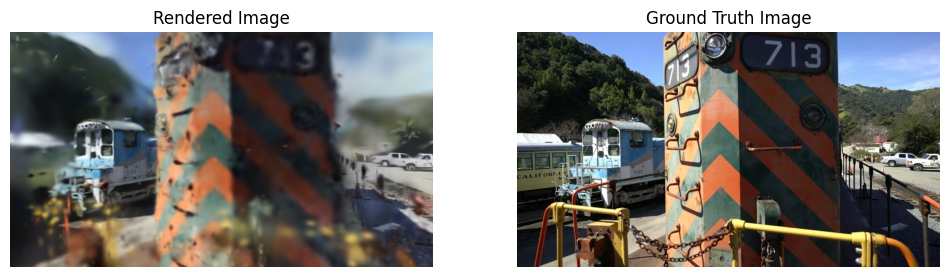

Training progress:   4%|▍         | 1180/30000 [00:24<07:55, 60.59it/s, Loss=0.1612275]

KeyboardInterrupt: 

In [9]:
if __name__ == "__main__":
    # Set up command line argument parser
    parser = ArgumentParser(description="Training script parameters")
    lp = ModelParams(parser)
    op = OptimizationParams(parser)
    pp = PipelineParams(parser)
    # Set up parameters directly in the script
    args = Namespace(
        sh_degree=3,
        source_path="./tandt/train", # 训练集路径
        model_path="", # 默认保存到output/随机码
        images="images",
        resolution=-1,
        white_background=False,
        data_device="cuda",
        eval=False,
        iterations=30000,
        position_lr_init=0.00016,
        position_lr_final=1.6e-06,
        position_lr_delay_mult=0.01,
        position_lr_max_steps=30000,
        feature_lr=0.0025,
        opacity_lr=0.05,
        scaling_lr=0.005,
        rotation_lr=0.001,
        percent_dense=0.01,
        lambda_dssim=0.2,
        densification_interval=100,
        opacity_reset_interval=3000,
        densify_from_iter=500,
        densify_until_iter=15000,
        densify_grad_threshold=0.0002,
        random_background=False,
        convert_SHs_python=False,
        compute_cov3D_python=False,
        debug=False,
        ip="127.0.0.1",
        port=6009,
        debug_from=-1,
        detect_anomaly=False,
        test_iterations=[100, 30000],
        save_iterations=[100, 30000, 30000],
        quiet=False,
        checkpoint_iterations=[],
        start_checkpoint=None
    )


    args.save_iterations.append(args.iterations)

    print("Optimizing " + args.model_path)

    # Initialize system state (RNG)
    safe_state(args.quiet)

    # Start GUI server, configure and run training
    # network_gui.init(args.ip, args.port)
    torch.autograd.set_detect_anomaly(args.detect_anomaly)
    training(lp.extract(args), op.extract(args), pp.extract(args), args.test_iterations, args.save_iterations, args.checkpoint_iterations, args.start_checkpoint, args.debug_from)

    # All done
    print("\nTraining complete.")



